<a href="https://colab.research.google.com/github/arpit-devop/predictive-analysis/blob/main/102353018_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


GAN TRAINING CONFIGURATION
Roll Number:     102353018
Parameter a_r:   2.50
Parameter b_r:   1.20
Architecture:    32 → 128 → 256 → 128 → 1

Loading and transforming data...
Data loaded: 414525 samples
Data range: [0.20, 93.40]

Training for 2000 epochs...
Epoch 500/2000 - D Loss: 1.5017, G Loss: 0.4744
Epoch 1000/2000 - D Loss: 1.4001, G Loss: 0.5081
Epoch 1500/2000 - D Loss: 1.3885, G Loss: 0.7229
Epoch 2000/2000 - D Loss: 1.3768, G Loss: 0.6925

Generating samples...
Creating visualizations...


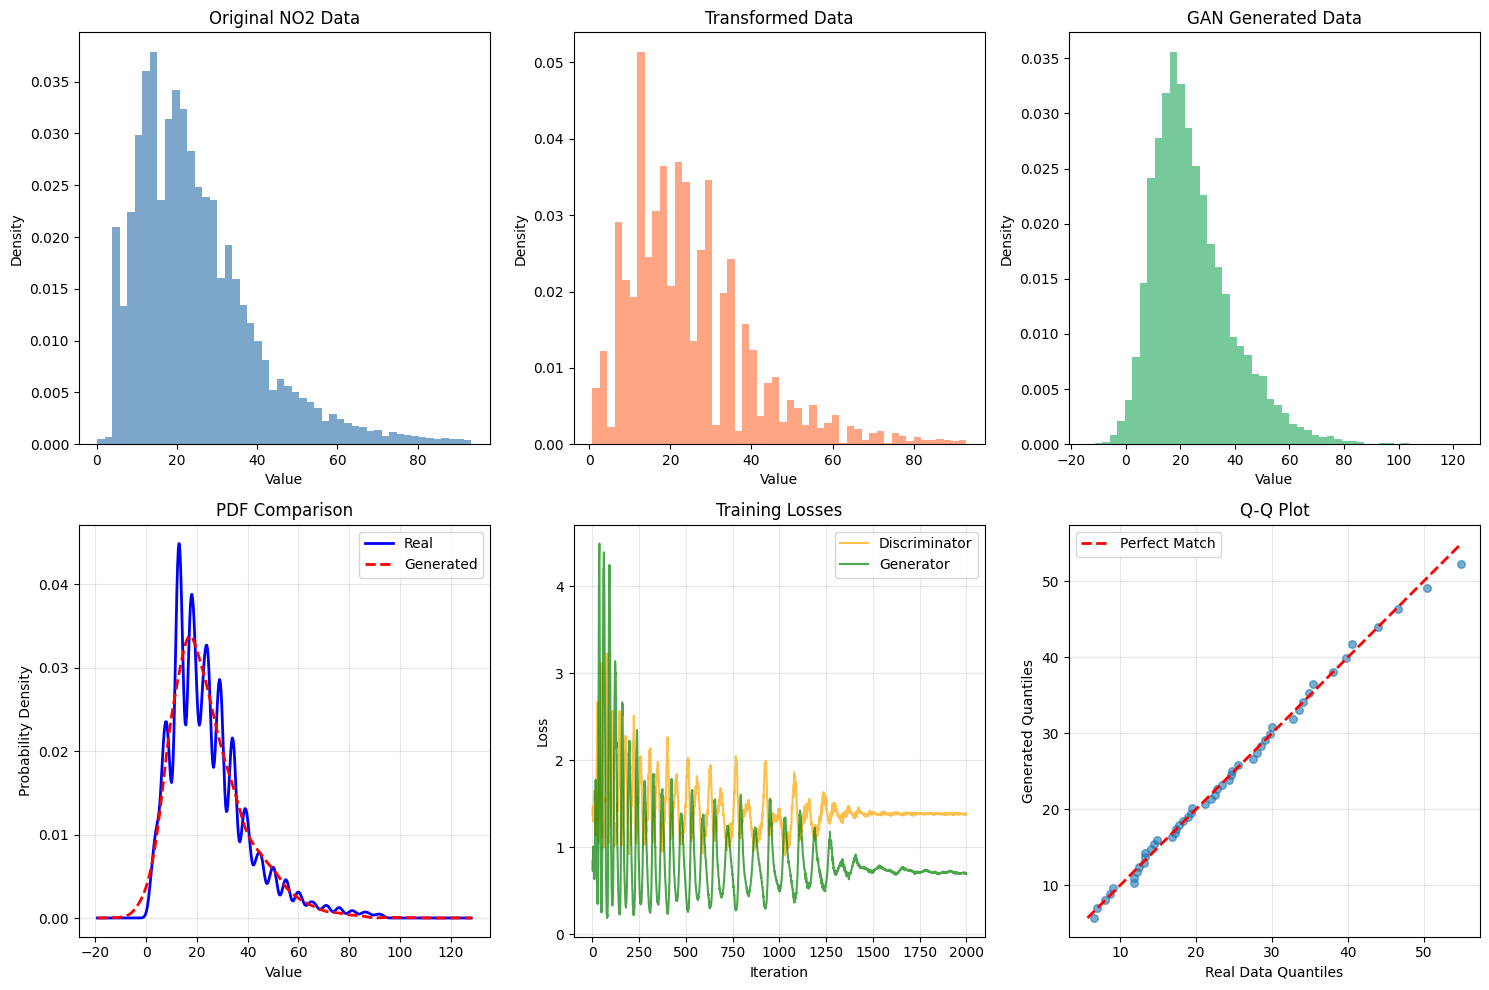

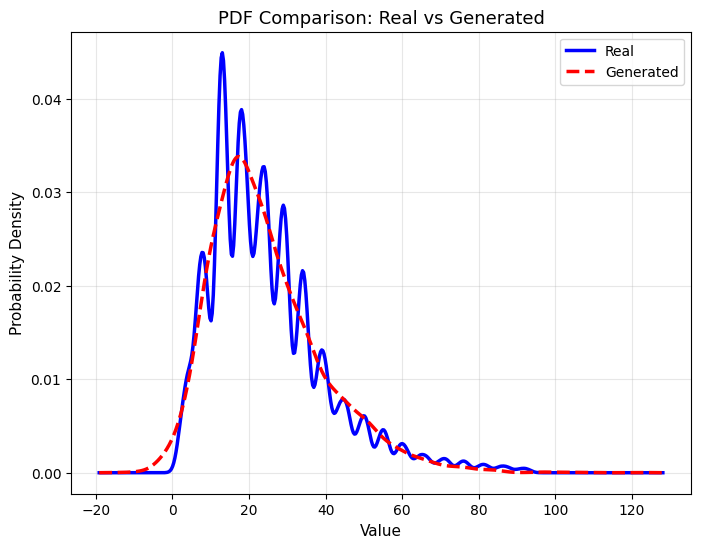


EVALUATION METRICS
KS Statistic:          0.0486
Wasserstein Distance:  0.80
Mean Difference:       0.42
Quality Assessment:    Good
Mode Coverage:         Good

✓ All plots saved successfully!
  - gan_results.png (comprehensive view)
  - pdf.png (detailed PDF comparison)



In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Personal parameters
ROLL = 102353018
a_r = 0.5 * (ROLL % 7)
b_r = 0.3 * (ROLL % 5 + 1)

def load_and_clean_data(path='/content/data.csv'):
    """Load NO2 data and remove outliers"""
    df = pd.read_csv(path, encoding='latin1')
    x = df["no2"].dropna().values
    x = x[(x > 0) & (x < np.percentile(x, 99))]
    return x

def transform(x):
    """Apply custom transformation based on roll number"""
    return x + a_r * np.sin(b_r * x)

class SimpleGAN:
    def __init__(self, latent=32, hidden=[128, 256, 128]):
        self.latent = latent
        self.hidden = hidden
        self.losses = {'d': [], 'g': []}
        self.step = 0

        # Initialize networks
        self._build_networks()

    def _build_networks(self):
        """Build generator and discriminator weights"""
        # Generator: noise -> data
        g_dims = [self.latent] + self.hidden + [1]
        self.gen = self._init_network(g_dims)

        # Discriminator: data -> real/fake
        d_dims = [1] + self.hidden + [1]
        self.disc = self._init_network(d_dims)

    def _init_network(self, dims):
        """Initialize network with He initialization and Adam moments"""
        net = {'w': [], 'b': [], 'mw': [], 'vw': [], 'mb': [], 'vb': []}
        for i in range(len(dims) - 1):
            scale = np.sqrt(2.0 / dims[i])
            net['w'].append(np.random.randn(dims[i], dims[i+1]) * scale)
            net['b'].append(np.zeros(dims[i+1]))
            net['mw'].append(np.zeros((dims[i], dims[i+1])))
            net['vw'].append(np.zeros((dims[i], dims[i+1])))
            net['mb'].append(np.zeros(dims[i+1]))
            net['vb'].append(np.zeros(dims[i+1]))
        return net

    def leaky_relu(self, x, alpha=0.2):
        return np.where(x > 0, x, alpha * x)

    def leaky_relu_grad(self, x, alpha=0.2):
        return np.where(x > 0, 1.0, alpha)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def forward_gen(self, noise):
        """Forward pass through generator"""
        self.g_cache = {'pre': [], 'act': [noise]}
        h = noise
        for i, (w, b) in enumerate(zip(self.gen['w'], self.gen['b'])):
            z = h @ w + b
            self.g_cache['pre'].append(z)
            h = z if i == len(self.gen['w']) - 1 else self.leaky_relu(z)
            self.g_cache['act'].append(h)
        return h

    def forward_disc(self, x):
        """Forward pass through discriminator"""
        self.d_cache = {'pre': [], 'act': [x.reshape(-1, 1)]}
        h = x.reshape(-1, 1)
        for i, (w, b) in enumerate(zip(self.disc['w'], self.disc['b'])):
            z = h @ w + b
            self.d_cache['pre'].append(z)
            h = self.sigmoid(z) if i == len(self.disc['w']) - 1 else self.leaky_relu(z)
            self.d_cache['act'].append(h)
        return h

    def adam_update(self, param, grad, m, v, lr=0.0002):
        """Adam optimizer update"""
        m = 0.9 * m + 0.1 * grad
        v = 0.999 * v + 0.001 * (grad ** 2)
        m_hat = m / (1 - 0.9 ** self.step)
        v_hat = v / (1 - 0.999 ** self.step)
        param -= lr * m_hat / (np.sqrt(v_hat) + 1e-8)
        return m, v

    def train_discriminator(self, real, fake, lr=0.0002):
        """Train discriminator on real and fake data"""
        batch_size = len(real)

        # Forward pass on real data
        real_pred = self.forward_disc(real)
        real_acts = [a.copy() for a in self.d_cache['act']]
        real_pres = [p.copy() for p in self.d_cache['pre']]

        # Forward pass on fake data
        fake_pred = self.forward_disc(fake)
        fake_acts = [a.copy() for a in self.d_cache['act']]
        fake_pres = [p.copy() for p in self.d_cache['pre']]

        # Compute loss
        d_loss = -np.mean(np.log(real_pred + 1e-8) + np.log(1 - fake_pred + 1e-8))

        # Backprop through real examples
        delta_real = (real_pred - 1) / batch_size
        grads_w_real, grads_b_real = [], []

        for i in range(len(self.disc['w']) - 1, -1, -1):
            grads_w_real.insert(0, real_acts[i].T @ delta_real)
            grads_b_real.insert(0, np.sum(delta_real, axis=0))
            if i > 0:
                delta_real = (delta_real @ self.disc['w'][i].T) * self.leaky_relu_grad(real_pres[i-1])

        # Backprop through fake examples
        delta_fake = fake_pred / batch_size
        grads_w_fake, grads_b_fake = [], []

        for i in range(len(self.disc['w']) - 1, -1, -1):
            grads_w_fake.insert(0, fake_acts[i].T @ delta_fake)
            grads_b_fake.insert(0, np.sum(delta_fake, axis=0))
            if i > 0:
                delta_fake = (delta_fake @ self.disc['w'][i].T) * self.leaky_relu_grad(fake_pres[i-1])

        # Update discriminator weights
        for i in range(len(self.disc['w'])):
            grad_w = np.clip(grads_w_real[i] + grads_w_fake[i], -1, 1)
            grad_b = np.clip(grads_b_real[i] + grads_b_fake[i], -1, 1)

            self.disc['mw'][i], self.disc['vw'][i] = self.adam_update(
                self.disc['w'][i], grad_w, self.disc['mw'][i], self.disc['vw'][i], lr
            )
            self.disc['mb'][i], self.disc['vb'][i] = self.adam_update(
                self.disc['b'][i], grad_b, self.disc['mb'][i], self.disc['vb'][i], lr
            )

        return d_loss

    def train_generator(self, batch_size, lr=0.0002):
        """Train generator to fool discriminator"""
        # Generate fake data
        noise = np.random.randn(batch_size, self.latent)
        fake = self.forward_gen(noise)

        # Get discriminator's prediction
        fake_pred = self.forward_disc(fake.flatten())

        # Generator loss
        g_loss = -np.mean(np.log(fake_pred + 1e-8))

        # Backprop from discriminator to generator
        delta = (fake_pred - 1) / batch_size

        # Backprop through discriminator (frozen weights)
        for i in range(len(self.disc['w']) - 1, 0, -1):
            delta = (delta @ self.disc['w'][i].T) * self.leaky_relu_grad(self.d_cache['pre'][i-1])

        delta_to_gen = delta @ self.disc['w'][0].T

        # Backprop through generator
        grads_w, grads_b = [], []
        delta_gen = delta_to_gen

        for i in range(len(self.gen['w']) - 1, -1, -1):
            grads_w.insert(0, self.g_cache['act'][i].T @ delta_gen)
            grads_b.insert(0, np.sum(delta_gen, axis=0))
            if i > 0:
                delta_gen = (delta_gen @ self.gen['w'][i].T) * self.leaky_relu_grad(self.g_cache['pre'][i-1])

        # Update generator weights
        for i in range(len(self.gen['w'])):
            grad_w = np.clip(grads_w[i], -1, 1)
            grad_b = np.clip(grads_b[i], -1, 1)

            self.gen['mw'][i], self.gen['vw'][i] = self.adam_update(
                self.gen['w'][i], grad_w, self.gen['mw'][i], self.gen['vw'][i], lr
            )
            self.gen['mb'][i], self.gen['vb'][i] = self.adam_update(
                self.gen['b'][i], grad_b, self.gen['mb'][i], self.gen['vb'][i], lr
            )

        return g_loss

    def fit(self, data, epochs=2000, batch_size=128, d_lr=0.0002, g_lr=0.0002):
        """Train the GAN"""
        # Normalize data
        self.mean = np.mean(data)
        self.std = np.std(data)
        norm_data = (data - self.mean) / (self.std + 1e-8)

        print(f"Training for {epochs} epochs...")
        for epoch in range(epochs):
            self.step += 1

            # Sample random batch
            idx = np.random.randint(0, len(norm_data), batch_size)
            real_batch = norm_data[idx]

            # Generate fake data
            noise = np.random.randn(batch_size, self.latent)
            fake_batch = self.forward_gen(noise).flatten()

            # Train discriminator and generator
            d_loss = self.train_discriminator(real_batch, fake_batch, d_lr)
            g_loss = self.train_generator(batch_size, g_lr)

            self.losses['d'].append(d_loss)
            self.losses['g'].append(g_loss)

            if (epoch + 1) % 500 == 0:
                print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

    def sample(self, n=10000):
        """Generate new samples"""
        noise = np.random.randn(n, self.latent)
        samples = self.forward_gen(noise)
        return samples.flatten() * (self.std + 1e-8) + self.mean

def plot_results(original, transformed, generated, gan):
    """Visualize GAN results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot 1: Original data histogram
    axes[0, 0].hist(original, bins=50, density=True, alpha=0.7, color='steelblue')
    axes[0, 0].set_title("Original NO2 Data", fontsize=12)
    axes[0, 0].set_xlabel("Value")
    axes[0, 0].set_ylabel("Density")

    # Plot 2: Transformed data histogram
    axes[0, 1].hist(transformed, bins=50, density=True, alpha=0.7, color='coral')
    axes[0, 1].set_title("Transformed Data", fontsize=12)
    axes[0, 1].set_xlabel("Value")
    axes[0, 1].set_ylabel("Density")

    # Plot 3: Generated data histogram
    axes[0, 2].hist(generated, bins=50, density=True, alpha=0.7, color='mediumseagreen')
    axes[0, 2].set_title("GAN Generated Data", fontsize=12)
    axes[0, 2].set_xlabel("Value")
    axes[0, 2].set_ylabel("Density")

    # Plot 4: PDF comparison
    kde_real = stats.gaussian_kde(transformed, bw_method='scott')
    kde_gen = stats.gaussian_kde(generated, bw_method='scott')
    x_range = np.linspace(
        min(transformed.min(), generated.min()) - 5,
        max(transformed.max(), generated.max()) + 5,
        500
    )

    axes[1, 0].plot(x_range, kde_real(x_range), label='Real', linewidth=2, color='blue')
    axes[1, 0].plot(x_range, kde_gen(x_range), label='Generated', linewidth=2,
                    linestyle='--', color='red')
    axes[1, 0].set_title("PDF Comparison", fontsize=12)
    axes[1, 0].set_xlabel("Value")
    axes[1, 0].set_ylabel("Probability Density")
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    # Plot 5: Training loss curves
    axes[1, 1].plot(gan.losses['d'], label='Discriminator', alpha=0.7, color='orange')
    axes[1, 1].plot(gan.losses['g'], label='Generator', alpha=0.7, color='green')
    axes[1, 1].set_title("Training Losses", fontsize=12)
    axes[1, 1].set_xlabel("Iteration")
    axes[1, 1].set_ylabel("Loss")
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    # Plot 6: Q-Q plot
    percentiles = np.linspace(5, 95, 50)
    real_q = np.percentile(transformed, percentiles)
    gen_q = np.percentile(generated, percentiles)
    axes[1, 2].scatter(real_q, gen_q, alpha=0.6, s=30)
    lims = [min(real_q.min(), gen_q.min()), max(real_q.max(), gen_q.max())]
    axes[1, 2].plot(lims, lims, 'r--', linewidth=2, label='Perfect Match')
    axes[1, 2].set_title("Q-Q Plot", fontsize=12)
    axes[1, 2].set_xlabel("Real Data Quantiles")
    axes[1, 2].set_ylabel("Generated Quantiles")
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("gan_results.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Separate PDF plot
    plt.figure(figsize=(8, 6))
    plt.plot(x_range, kde_real(x_range), label='Real', linewidth=2.5, color='blue')
    plt.plot(x_range, kde_gen(x_range), label='Generated', linewidth=2.5,
             linestyle='--', color='red')
    plt.xlabel("Value", fontsize=11)
    plt.ylabel("Probability Density", fontsize=11)
    plt.title("PDF Comparison: Real vs Generated", fontsize=13)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.savefig("pdf.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Calculate and display metrics
    ks_stat = stats.ks_2samp(transformed, generated)[0]
    w_dist = stats.wasserstein_distance(transformed, generated)
    mean_diff = abs(np.mean(transformed) - np.mean(generated))

    print(f"\n{'='*50}")
    print(f"EVALUATION METRICS")
    print(f"{'='*50}")
    print(f"KS Statistic:          {ks_stat:.4f}")
    print(f"Wasserstein Distance:  {w_dist:.2f}")
    print(f"Mean Difference:       {mean_diff:.2f}")
    print(f"Quality Assessment:    {'Good' if w_dist < 7 else 'Moderate'}")
    print(f"Mode Coverage:         {'Good' if mean_diff < 5 else 'Needs Work'}")
    print(f"{'='*50}\n")

# Main execution
if __name__ == "__main__":
    print(f"\n{'='*50}")
    print(f"GAN TRAINING CONFIGURATION")
    print(f"{'='*50}")
    print(f"Roll Number:     {ROLL}")
    print(f"Parameter a_r:   {a_r:.2f}")
    print(f"Parameter b_r:   {b_r:.2f}")
    print(f"Architecture:    32 → 128 → 256 → 128 → 1")
    print(f"{'='*50}\n")

    # Load and transform data
    print("Loading and transforming data...")
    original_data = load_and_clean_data('/content/data.csv')
    transformed_data = transform(original_data)
    print(f"Data loaded: {len(original_data)} samples")
    print(f"Data range: [{original_data.min():.2f}, {original_data.max():.2f}]\n")

    # Train GAN
    gan = SimpleGAN(latent=32, hidden=[128, 256, 128])
    gan.fit(transformed_data, epochs=2000, batch_size=128)

    # Generate samples
    print("\nGenerating samples...")
    generated_data = gan.sample(10000)

    # Visualize results
    print("Creating visualizations...")
    plot_results(original_data, transformed_data, generated_data, gan)

    print("✓ All plots saved successfully!")
    print("  - gan_results.png (comprehensive view)")
    print("  - pdf.png (detailed PDF comparison)\n")